In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchinfo import summary
import copy
import time

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl

pl.seed_everything(9999)

Global seed set to 9999


9999

In [2]:
#lake mask
dk_lakes_dir = "dk_lakes_mask/"
dk_lakes_path = os.listdir(dk_lakes_dir)

dk_lakes_list = []

for i in dk_lakes_path:
    lake_path = dk_lakes_dir+i
    lake_array = cv2.imread(lake_path, cv2.IMREAD_UNCHANGED)
    lake_array_float = lake_array.astype("float32") / 255.0
    dk_lakes_list.append(lake_array_float)


In [3]:
data = np.load("data.npz")
dem = data["dem"]


In [4]:
train = dem[:8000]
valid = dem[8000:]

In [5]:
dk_lakes_valid = np.stack(dk_lakes_list+dk_lakes_list)

In [6]:
class DEMTrain(Dataset):

    def __init__(self, array, masks):
      
        self.array = array
        self.masks = masks
                
        self.dem_transform = A.Compose([
            A.RandomRotate90(p=0.25),
            A.Flip(p=0.25)
        ])
        
        self.mask_transform = A.Compose([
            A.ShiftScaleRotate(p=0.25, scale_limit=(0.5, 1.5), 
                               interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT),
            A.RandomRotate90(p=0.25),
            A.Flip(p=0.25)
        ])

    def __getitem__(self, idx):

        target = self.array[idx]
        target_transformed = self.dem_transform(image=target)
        target_trans = target_transformed["image"]
        target_tensor = torch.from_numpy(target_trans).unsqueeze(0)
        
        mask = random.choice(self.masks)
        mask_transformed = self.mask_transform(image=mask)
        mask_trans = mask_transformed["image"]
        mask_tensor = torch.from_numpy(mask_trans).unsqueeze(0)
        
        input_tensor = target_tensor*(1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return self.array.shape[0]

In [7]:
class DEMValid(Dataset):

    def __init__(self, array, masks):
      
        self.array = array
        self.masks = masks

    def __getitem__(self, idx):

        target = self.array[idx]
        target_tensor = torch.from_numpy(target).unsqueeze(0)
        
        mask = self.masks[idx]
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        input_tensor = target_tensor*(1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return self.array.shape[0]

In [8]:
train_dataset = DEMTrain(train, dk_lakes_list)
valid_dataset = DEMValid(valid, dk_lakes_valid)


(256, 256)
float32
0.62053055
0.0


<Figure size 432x288 with 0 Axes>

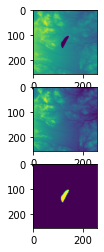

In [9]:
#Example
tmp_in, tmp_target, tmp_mask = train_dataset[5]

tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_mask_np)

print(tmp_in_np.shape)
print(tmp_in_np.dtype)
print(tmp_in_np.max())
print(tmp_in_np.min())

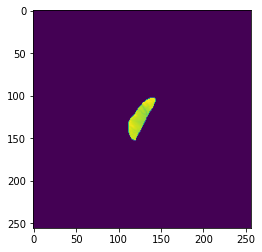

In [10]:
plt.imshow(tmp_target_np*tmp_mask_np)

In [56]:
from unet_network import UNet

class MSELossWeighted(nn.Module):
    def __init__(self, w_hole = 5, w_nonhole = 1):
        super().__init__()
        self.l2 = nn.MSELoss()
        self.w_hole = w_hole
        self.w_nonhole = w_nonhole

    def forward(self, hat, truth, mask):
        
        l2_hole = self.l2(hat * mask, truth * mask)
        l2_nonhole = self.l2(hat * (1-mask), truth * (1-mask))
        
        l2_total = (l2_hole*self.w_hole) + (l2_nonhole*self.w_nonhole)

        return l2_total

In [58]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, init_features = 16, channels = 1):
        super().__init__()
        
        features = init_features
        
        self.unet = UNet(in_channels=1, out_channels=1, init_features=8)
        
        self.loss = MSELossWeighted()
        

    def forward(self, x):
        x_hat = self.unet(x)
        return x_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_in, x_truth, mask = train_batch
        x_hat=self.unet(x_in)
        loss = self.loss(x_hat, x_truth, mask)
        self.log('train_loss', loss)
        return {'loss': loss}

    def validation_step(self, val_batch, batch_idx):
        x_in, x_truth, mask = val_batch
        x_hat=self.unet(x_in)
        loss = self.loss(x_hat, x_truth, mask)
        self.log('val_loss', loss)


In [59]:

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=8)
val_loader = DataLoader(valid_dataset, batch_size=64, num_workers=8)

# model
model = LitAutoEncoder()


In [60]:
#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
#trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss")])

#load weights
#model = MyLightingModule.load_from_checkpoint(PATH)

#resume training from checkpoint
#trainer.fit(model, ckpt_path="some/path/to/my_checkpoint.ckpt")


In [61]:
# training
trainer = pl.Trainer(gpus=1, max_epochs=100)
trainer.fit(model, train_loader, val_loader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | unet | UNet            | 486 K 
1 | loss | MSELossWeighted | 0     
-----------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.946     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 9999


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [65]:
# training
trainer = pl.Trainer(gpus=1, max_epochs=200)
trainer.fit(model, train_loader, val_loader, ckpt_path="lightning_logs/version_2/checkpoints/epoch=99-step=12499.ckpt")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at lightning_logs/version_2/checkpoints/epoch=99-step=12499.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint file at lightning_logs/version_2/checkpoints/epoch=99-step=12499.ckpt

  | Name | Type            | Params
-----------------------------------------
0 | unet | UNet            | 486 K 
1 | loss | MSELossWeighted | 0     
-----------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.946     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 9999


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# training
trainer = pl.Trainer(gpus=1, max_epochs=400)
trainer.fit(model, train_loader, val_loader, ckpt_path="lightning_logs/version_4/checkpoints/epoch=199-step=24999.ckpt")


In [66]:
plt.rcParams['figure.dpi'] = 200


<Figure size 1200x800 with 0 Axes>

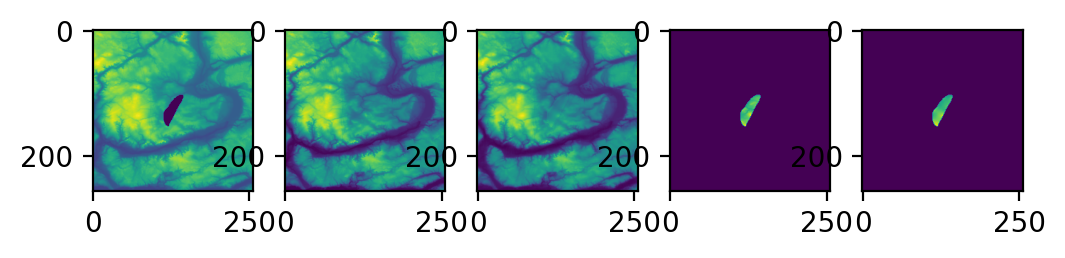

In [67]:
tmp_in, tmp_target, tmp_mask = train_dataset[60]

with torch.no_grad():
    tmp_model_out = model(tmp_in.unsqueeze(0))
        
plt.figure()
f, axarr = plt.subplots(1,5)
axarr[0].imshow(tmp_in.squeeze().numpy())
axarr[1].imshow(tmp_target.squeeze().numpy())
axarr[2].imshow(tmp_model_out.squeeze().numpy())
axarr[3].imshow(tmp_target.squeeze().numpy() * tmp_mask.squeeze().numpy())
axarr[4].imshow(tmp_model_out.squeeze().numpy() * tmp_mask.squeeze().numpy())


In [ ]:
#tensorboard --logdir=lightning_logs/
